In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator
# import seaborn as sns
# import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from machinelearning.Bootstrap import Bootstrap
from machinelearning.CrossValidation import kfold_cross_validation
from machinelearning.Data import generate_functional_data
from machinelearning.LassoRegression import LassoRegression
from machinelearning.LinearRegression import LinearRegression
from machinelearning.RidgeRegression import RidgeRegression, SVDRidgeRegression
from machinelearning.Sampler import Sampler
from machinelearning.utils import validate_data, validate_features_dimension

# sns.set_theme(context="notebook", style="ticks")
# plt.style.use('bmh')
plt.style.use("ggplot")

np.random.seed(42)

# Data generation

In [2]:
data_params_1 = {
    "x": 2 - 3 * np.random.normal(0, 1, 40),
    "f": lambda x: x - 2 * (x**2) + 0.5 * (x**3),
    "mean_sd": (0, 15),
}

data_params_2 = {
    "x": np.linspace(-10, 10, 70),
    "f": lambda x: 1 + 2 * (x**2),
    "mean_sd": (0, 3),
}

x, y = generate_functional_data(**data_params_1)
f = data_params_1["f"]
w_true = np.array([0.0, 1.0, -2.0, 0.5]).reshape((-1, 1))

## Model

In [3]:
def plot(
    cv_scores: dict[str, np.ndarray],
    model_params: range | np.ndarray,
    x,
    y,
    y_hats,
    title: str = "Regression",
):
    def plot_y_hats(ax, y_hats, degrees):
        """Plot fitted polynomials."""
        for i, degree in enumerate(degrees):
            data: np.ndarray = np.concatenate([x, y_hats[i].reshape((-1, 1))], axis=1)
            data = data[np.argsort(data[:, 0], axis=0), :]
            ax.plot(data[:, 0], data[:, 1], label=f"model param {degree}")

        ax.legend(loc="upper left", prop={"size": 10})
        ax.set_title("Fitted data")
        ax.set_xlabel("x")
        ax.set_ylabel("y")

    def plot_bias_variance_tradeoff(
        ax,
        cv_scores: dict[str, np.ndarray],
        labels: list[str],
        model_params: np.ndarray,
        title: str = "Bias-variance tradeoff",
    ):
        # labels: list[str] = ["w_hat_bias", "w_hat_var"]
        labels = [f"test_{lb}" for lb in labels]
        scores: np.ndarray = np.array([cv_scores[lb] for lb in labels])
        normalized_scores: np.ndarray = (scores / scores.max() * 100).astype("int8")
        for i, lb in enumerate(labels):
            ax.plot(range(len(model_params)), normalized_scores[i], "-o", label=lb)

        ax.set_xticks(
            range(len(model_params)), model_params.round(decimals=2), rotation=15.0
        )
        ax.set_xlabel("model param")
        ax.set_ylabel("percents(%)")

        ax.legend(loc="upper right", prop={"size": 10})
        ax.set_title(title)

    gridsize = (3, 2)
    fig = plt.figure(figsize=(12, 12))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (2, 0))
    ax3 = plt.subplot2grid(gridsize, (2, 1))
    # fig, ((ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 12))

    # plot (x, y) data
    ax1.scatter(x, y, s=15, c="black", marker="o", label="data")

    model_params = np.array(model_params)
    plot_y_hats(ax1, y_hats, model_params)
    plot_bias_variance_tradeoff(
        ax2,
        cv_scores,
        ["bias_y_hat", "var_y_hat", "bs_mse"],
        model_params,
        title="f_hat bias-variance tradeoff",
    )
    plot_bias_variance_tradeoff(
        ax3,
        cv_scores,
        ["bs_w_hat_bias", "bs_w_hat_var"],
        model_params,
        title="w_hat bias-variance tradeoff",
    )

    plt.suptitle(title)
    plt.tight_layout()
    plt.show(fig)

In [4]:
degrees = range(2, 7)
pf = PolynomialFeatures()
estimator = LinearRegression(transformer=pf)
bs_sampler = Sampler(type="cheating", f=f)
bs = Bootstrap(estimator, bs_sampler, n_bootstraps=100)
n_cv_splits = 4


cv_scores: dict[str, np.ndarray] = {}
y_hats: list[np.ndarray] = []
for i, degree in enumerate(degrees):
    # set degree of polynomial features
    pf.degree = degree
    # calculate cv scores
    score = kfold_cross_validation(bs, x, y, f, w_true, n_cv_splits)
    # estimate w_hat on all data
    y_hats.append(estimator.fit(x, y).predict(x).flatten())
    # fill cv_scores dict
    for k, v in score.items():
        if k not in cv_scores.keys():
            cv_scores[k] = np.zeros(len(degrees))
        cv_scores[k][i] = v

# print(pd.DataFrame(cv_scores.values(), index=list(cv_scores.keys()), columns=degrees))
pd.DataFrame(cv_scores, index=degrees)

,test_r2,test_adj_r2,test_mse,test_bs_mse,test_bias_y_hat,test_var_y_hat,test_cond_num,test_bs_w_hat_bias,test_bs_w_hat_var,train_r2,train_adj_r2,train_mse,train_bs_mse,train_bias_y_hat,train_var_y_hat,train_cond_num
2,0.562464,0.437453,365.776775,486.865457,387.652464,19.515272,32.228313,91.321694,3.155290,0.799412,0.784554,283.165274,313.643837,189.306405,13.895131,32.228313
3,0.618851,0.428276,221.589042,267.060010,0.436796,64.076098,286.750028,0.087068,6.328135,0.847399,0.829791,173.355336,226.610322,0.550221,20.559727,286.750028
4,0.741284,0.534311,262.075011,264.917603,3.362308,39.726022,2622.478366,0.662652,7.690317,0.884793,0.866360,163.486200,231.444254,3.674551,28.242014,2622.478366
5,0.636493,0.182110,311.009267,484.465703,5.534678,259.379449,21616.032536,0.320592,14.424300,0.872120,0.845478,162.745699,241.422543,1.377303,36.695848,21616.032536
6,0.683458,0.050375,317.435418,599.651570,7.864668,365.940308,180857.574599,0.220989,13.019810,0.895051,0.867673,153.166639,247.116827,1.456307,41.904429,180857.574599


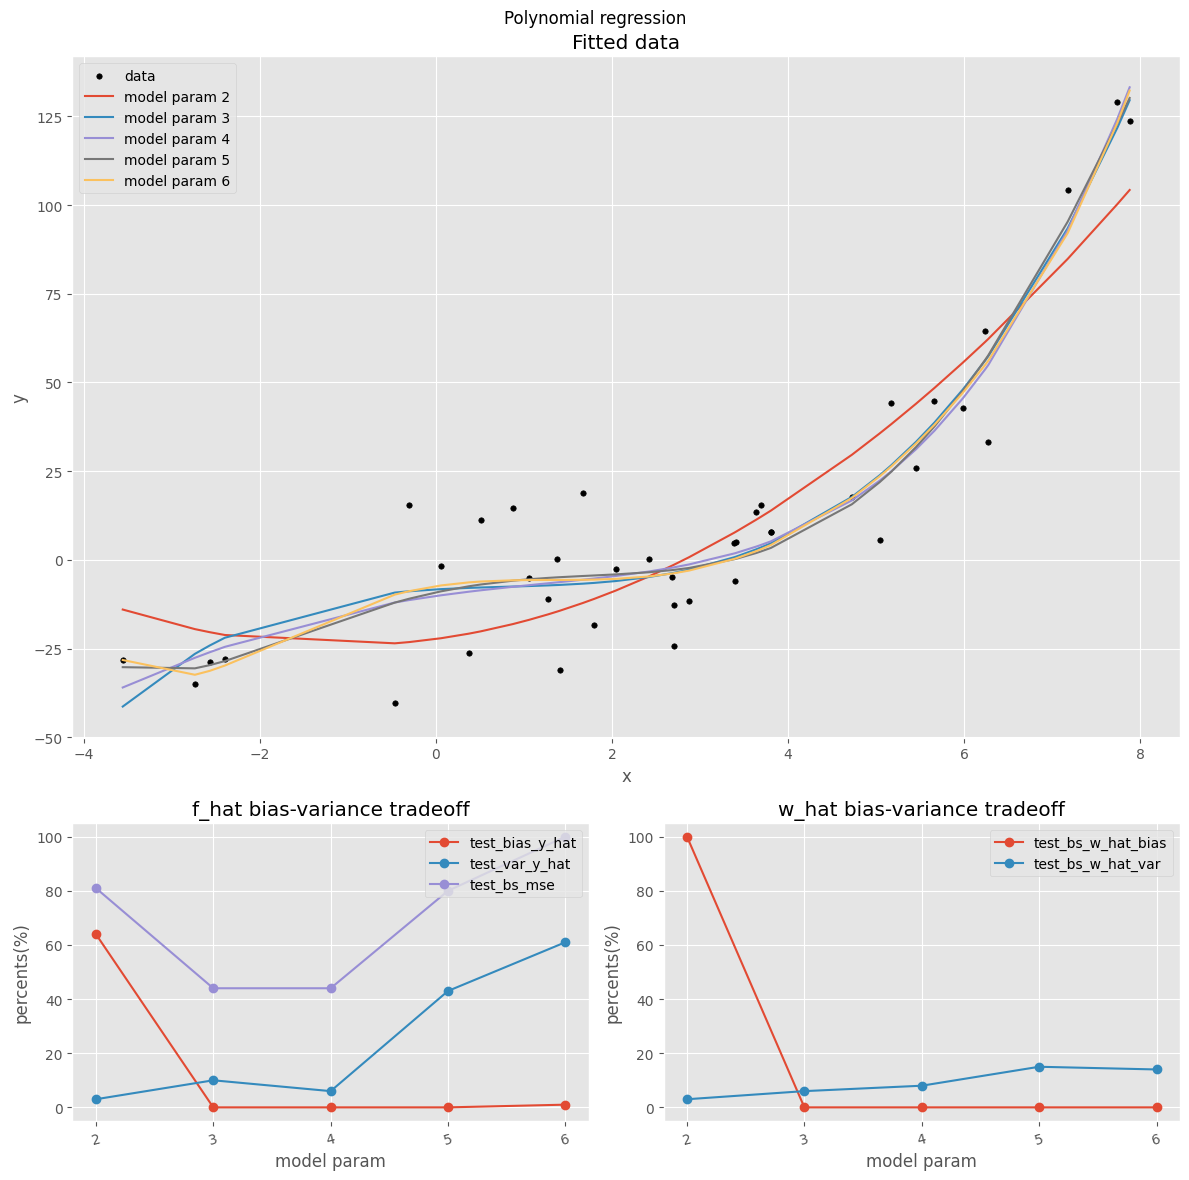

In [5]:
plot(cv_scores, degrees, x, y, y_hats, title="Polynomial regression")

In [6]:
alphas = np.insert(np.logspace(0, 3, 5), 0, 0.0)
pf = PolynomialFeatures(degree=3)
estimator = RidgeRegression(transformer=pf)
bs_sampler = Sampler(type="cheating", f=f)
bs = Bootstrap(estimator, bs_sampler, n_bootstraps=100)
n_cv_splits = 4


cv_scores: dict[str, np.ndarray] = {}
y_hats: list[np.ndarray] = []
for i, alpha in enumerate(alphas):
    # set estimator's alpha
    estimator.alpha = alpha
    # calculate cv scores
    score = kfold_cross_validation(bs, x, y, f, w_true, n_cv_splits)
    # estimate w_hat on all data
    y_hats.append(estimator.fit(x, y).predict(x).flatten())
    # fill cv_scores dict
    for k, v in score.items():
        if k not in cv_scores.keys():
            cv_scores[k] = np.zeros(len(alphas))
        cv_scores[k][i] = v

pd.DataFrame(cv_scores, index=alphas)

,test_r2,test_adj_r2,test_mse,test_bs_mse,test_bias_y_hat,test_var_y_hat,test_cond_num,test_bs_w_hat_bias,test_bs_w_hat_var,train_r2,train_adj_r2,train_mse,train_bs_mse,train_bias_y_hat,train_var_y_hat,train_cond_num
0.000000,0.770698,0.656046,201.966048,247.990708,2.477241,28.404791,293.449126,0.572982,4.752265,0.874718,0.860262,174.724052,220.521754,2.419923,19.164017,293.449126
1.000000,0.464493,0.196740,233.998866,250.613472,3.257744,26.960075,293.411846,0.480017,4.276492,0.877260,0.863097,170.267962,223.148980,2.996490,20.175136,293.411846
5.623413,0.661528,0.492291,257.875583,229.624702,0.969522,24.459630,290.363912,0.115618,2.289292,0.875633,0.861283,172.744161,218.910523,0.756427,16.205221,290.363912
31.622777,0.732312,0.598467,202.546900,227.694994,2.221106,16.386288,291.266892,0.072182,0.551514,0.871045,0.856166,187.231210,215.543302,2.646372,12.757909,291.266892
177.827941,0.795876,0.693815,210.266657,216.304514,11.818903,9.606637,291.378408,0.235951,0.092245,0.868147,0.852933,194.732093,211.041481,5.206442,9.173690,291.378408
1000.000000,0.745638,0.618457,232.374400,230.289403,36.967250,6.777563,295.216386,0.553681,0.010779,0.846025,0.828259,216.715915,219.736081,31.140043,5.772610,295.216386


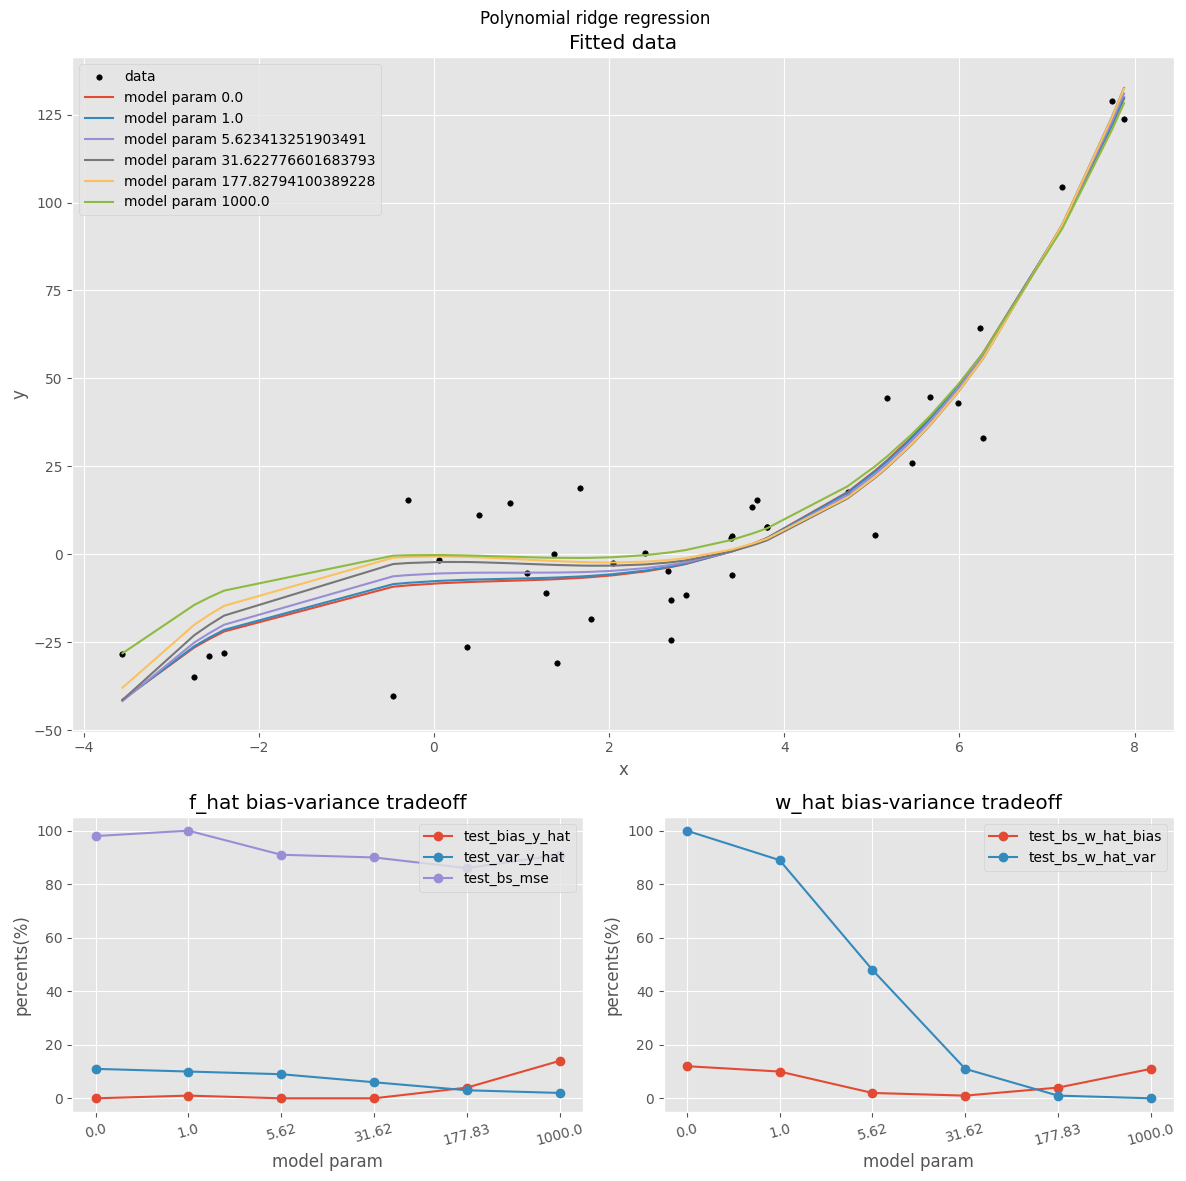

In [7]:
plot(cv_scores, alphas, x, y, y_hats, title="Polynomial ridge regression")

In [8]:
degrees = range(2, 7)
pf = PolynomialFeatures()
estimator = SVDRidgeRegression(transformer=pf, alpha=10e3)
bs_sampler = Sampler(type="cheating", f=f)
bs = Bootstrap(estimator, bs_sampler, n_bootstraps=100)
n_cv_splits = 4


cv_scores: dict[str, np.ndarray] = {}
y_hats: list[np.ndarray] = []
for i, degree in enumerate(degrees):
    # set degree of polynomial features
    pf.degree = degree
    # calculate cv scores
    score = kfold_cross_validation(bs, x, y, f, w_true, n_cv_splits)
    # estimate w_hat on all data
    y_hats.append(estimator.fit_predict(x, y).flatten())
    # fill cv_scores dict
    for k, v in score.items():
        if k not in cv_scores.keys():
            cv_scores[k] = np.zeros(len(degrees))
        cv_scores[k][i] = v

pd.DataFrame(cv_scores, index=degrees)

,test_r2,test_adj_r2,test_mse,test_bs_mse,test_bias_y_hat,test_var_y_hat,test_cond_num,test_bs_w_hat_bias,test_bs_w_hat_var,train_r2,train_adj_r2,train_mse,train_bs_mse,train_bias_y_hat,train_var_y_hat,train_cond_num
2,0.497756,0.354257,727.997344,778.301147,569.340546,1.310348,32.240605,2.198902,0.000892,0.522080,0.486678,712.825833,758.044940,536.484204,1.271937,32.240605
3,0.537087,0.305631,288.301944,318.369565,136.802120,7.741527,290.944722,1.132501,0.000341,0.801234,0.778299,271.465963,282.376425,104.765316,4.858021,290.944722
4,0.710722,0.479300,300.342675,304.590609,127.133396,10.635397,2533.750367,0.914803,0.001101,0.812584,0.782597,268.678934,279.902454,103.212452,8.340690,2533.750367
5,0.742099,0.419723,284.503034,291.158084,89.722725,14.862060,21022.474898,0.820725,0.000964,0.835476,0.801201,243.443943,263.752446,42.909060,12.434464,21022.474898
6,0.603958,-0.188126,315.356714,306.096397,29.885952,27.927621,188375.782122,0.737383,0.000677,0.852161,0.813595,215.992982,250.184510,11.361331,16.225437,188375.782122


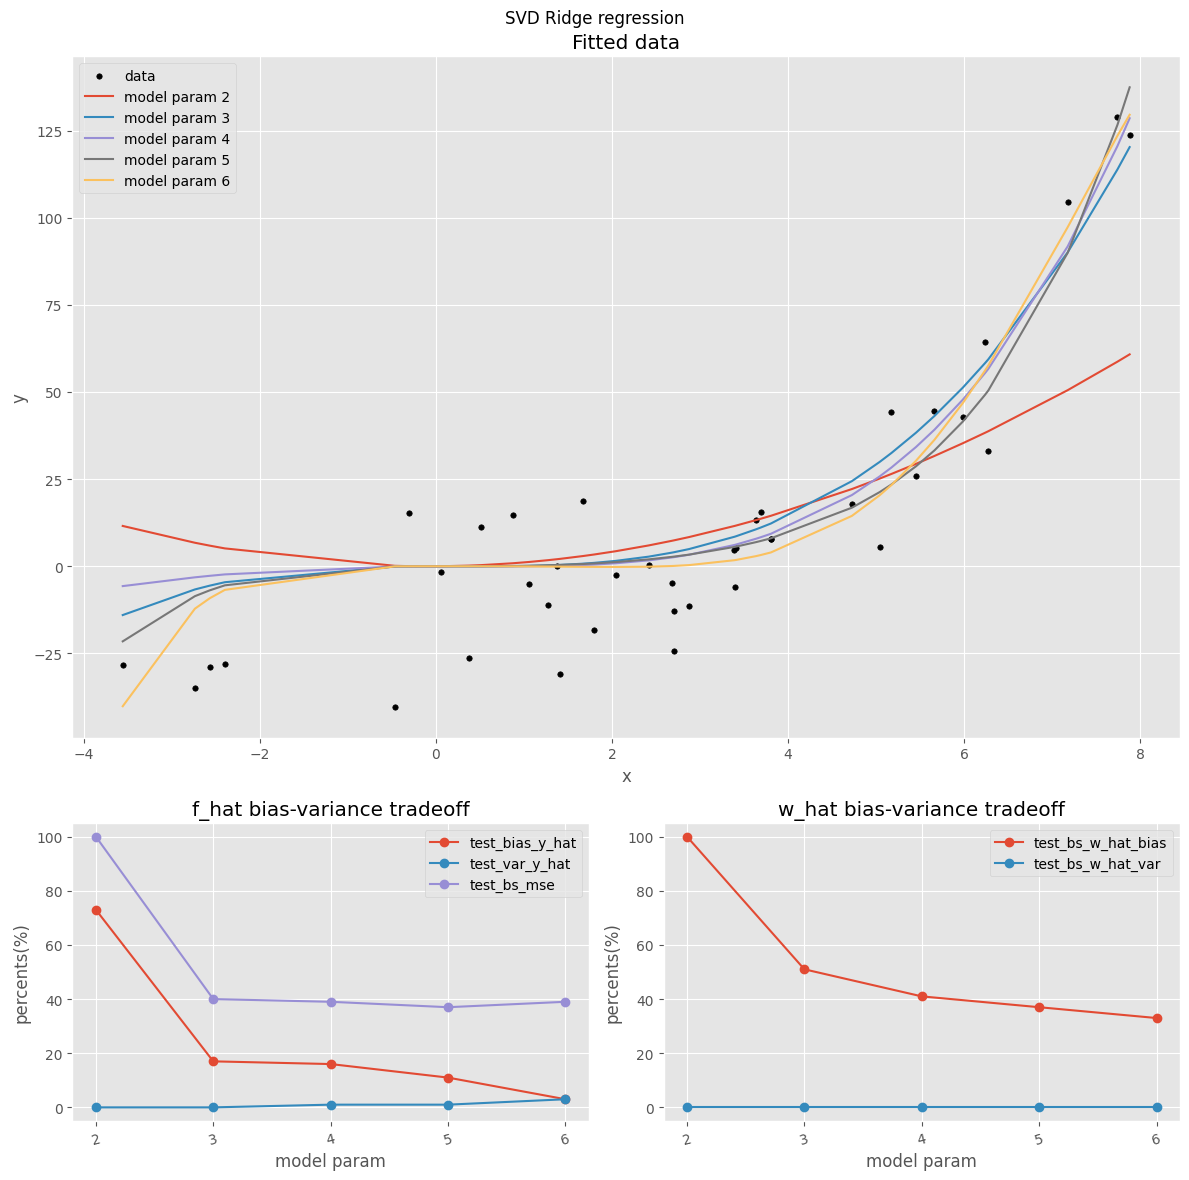

In [9]:
plot(cv_scores, degrees, x, y, y_hats, title="SVD Ridge regression")

In [10]:
degrees = range(2, 7)
pf = PolynomialFeatures()
estimator = LassoRegression(transformer=pf, alpha=10e3)
bs_sampler = Sampler(type="cheating", f=f)
bs = Bootstrap(estimator, bs_sampler, n_bootstraps=100)
n_cv_splits = 4


cv_scores: dict[str, np.ndarray] = {}
y_hats: list[np.ndarray] = []
for i, degree in enumerate(degrees):
    # set degree of polynomial features
    pf.degree = degree
    # calculate cv scores
    score = kfold_cross_validation(bs, x, y, f, w_true, n_cv_splits)
    # estimate w_hat on all data
    y_hats.append(estimator.fit(x, y).predict(x).flatten())
    # fill cv_scores dict
    for k, v in score.items():
        if k not in cv_scores.keys():
            cv_scores[k] = np.zeros(len(degrees))
        cv_scores[k][i] = v

pd.DataFrame(cv_scores, index=degrees)

,test_r2,test_adj_r2,test_mse,test_bs_mse,test_bias_y_hat,test_var_y_hat,test_cond_num,test_bs_w_hat_bias,test_bs_w_hat_var,train_r2,train_adj_r2,train_mse,train_bs_mse,train_bias_y_hat,train_var_y_hat,train_cond_num
2,-0.084283,-0.394078,1618.938366,1618.938366,1317.534937,0.000000,33.293104,1.312500,0.000000e+00,-0.079534,-0.159500,1618.938366,1618.938366,1317.534937,0.000000,33.293104
3,-0.164089,-0.746133,1618.938366,1618.938366,1317.534937,0.000000,294.721663,1.312500,0.000000e+00,-0.085392,-0.210629,1618.938366,1618.938366,1317.534937,0.000000,294.721663
4,0.693057,0.447502,398.360046,473.673582,255.127415,11.272848,2582.961917,1.050110,1.749913e-06,0.747770,0.707413,369.888455,443.027467,230.767616,9.178683,2582.961917
5,0.763994,0.468986,329.610563,316.058230,116.716867,10.217998,20988.942461,0.875003,2.432086e-08,0.803954,0.763111,291.833376,304.030974,113.430597,8.207732,20988.942461
6,0.630806,-0.107582,362.184677,359.919229,158.309838,11.911553,176775.768221,0.750000,3.372670e-08,0.761915,0.699806,343.404393,350.810449,150.538993,8.413894,176775.768221


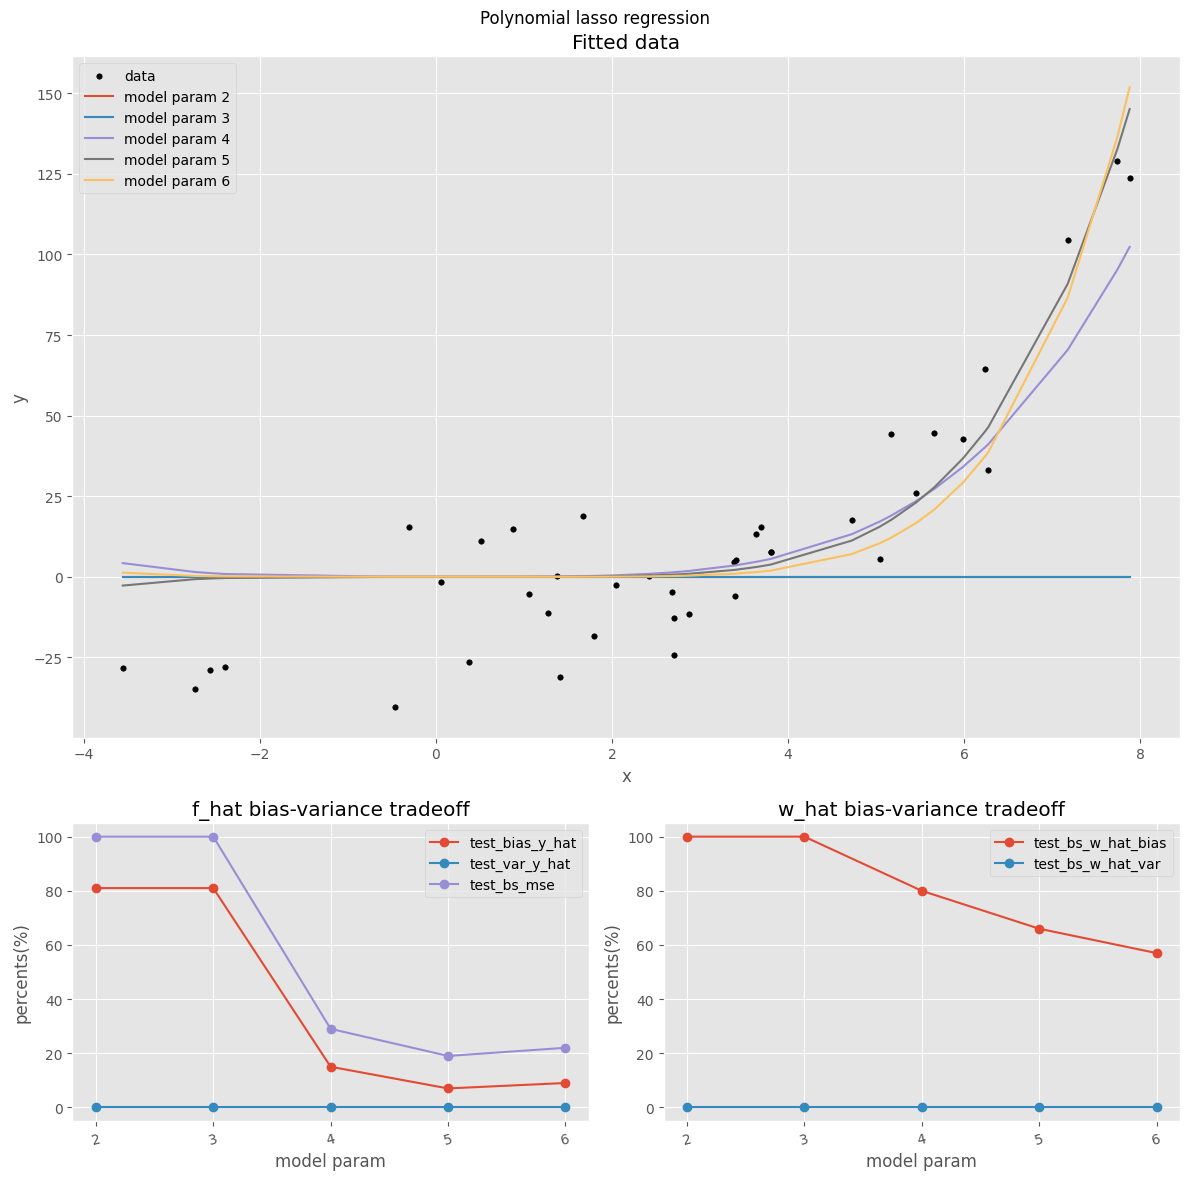

In [11]:
plot(cv_scores, degrees, x, y, y_hats, title="Polynomial lasso regression")

In [12]:
alphas = np.insert(np.logspace(0, 3, 5), 0, 0.0)
pf = PolynomialFeatures(degree=3)
estimator = LassoRegression(transformer=pf)
bs_sampler = Sampler(type="cheating", f=f)
bs = Bootstrap(estimator, bs_sampler, n_bootstraps=100)
n_cv_splits = 4


cv_scores: dict[str, np.ndarray] = {}
y_hats: list[np.ndarray] = []
for i, alpha in enumerate(alphas):
    # set estimator's alpha
    estimator.alpha = alpha
    # calculate cv scores
    score = kfold_cross_validation(bs, x, y, f, w_true, n_cv_splits)
    # estimate w_hat on all data
    y_hats.append(estimator.fit(x, y).predict(x).flatten())
    # fill cv_scores dict
    for k, v in score.items():
        if k not in cv_scores.keys():
            cv_scores[k] = np.zeros(len(alphas))
        cv_scores[k][i] = v

pd.DataFrame(cv_scores, index=alphas)

/home/dl2718/code/computational-math/machinelearning/LassoRegression.py:26: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._w_hat = Lasso(alpha=self.alpha).fit(X, y).coef_.reshape((-1, 1))
/home/dl2718/code/computational-math/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/dl2718/code/computational-math/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.572e+03, tolerance: 3.897e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers

,test_r2,test_adj_r2,test_mse,test_bs_mse,test_bias_y_hat,test_var_y_hat,test_cond_num,test_bs_w_hat_bias,test_bs_w_hat_var,train_r2,train_adj_r2,train_mse,train_bs_mse,train_bias_y_hat,train_var_y_hat,train_cond_num
0.000000,0.657393,0.486089,270.418829,246.978088,0.470749,45.814538,294.324972,0.006110,0.786394,0.827245,0.807311,247.940338,243.204999,0.428103,40.089956,294.324972
1.000000,0.636179,0.454269,268.993020,242.677161,2.730302,42.151006,294.007351,0.030866,0.649918,0.824329,0.804060,262.693765,238.080143,0.520807,35.135193,294.007351
5.623413,0.795095,0.692643,282.153666,227.679096,9.397049,32.139991,291.553891,0.190030,0.218333,0.825108,0.804928,267.343471,233.539936,5.031027,30.495715,291.553891
31.622777,0.712675,0.569013,316.471826,290.331617,127.704269,12.372190,294.230988,1.119690,0.020781,0.786308,0.761652,317.276371,287.044811,122.662473,12.283590,294.230988
177.827941,0.769427,0.654141,302.831447,297.612112,137.063694,8.575850,292.423737,1.265327,0.000094,0.794486,0.770773,303.604212,294.865993,133.053840,8.206147,292.423737
1000.000000,0.662284,0.493426,331.052077,380.296629,178.161334,10.715481,290.679810,1.272526,0.000110,0.791485,0.767425,297.787088,334.994577,144.275426,9.370675,290.679810


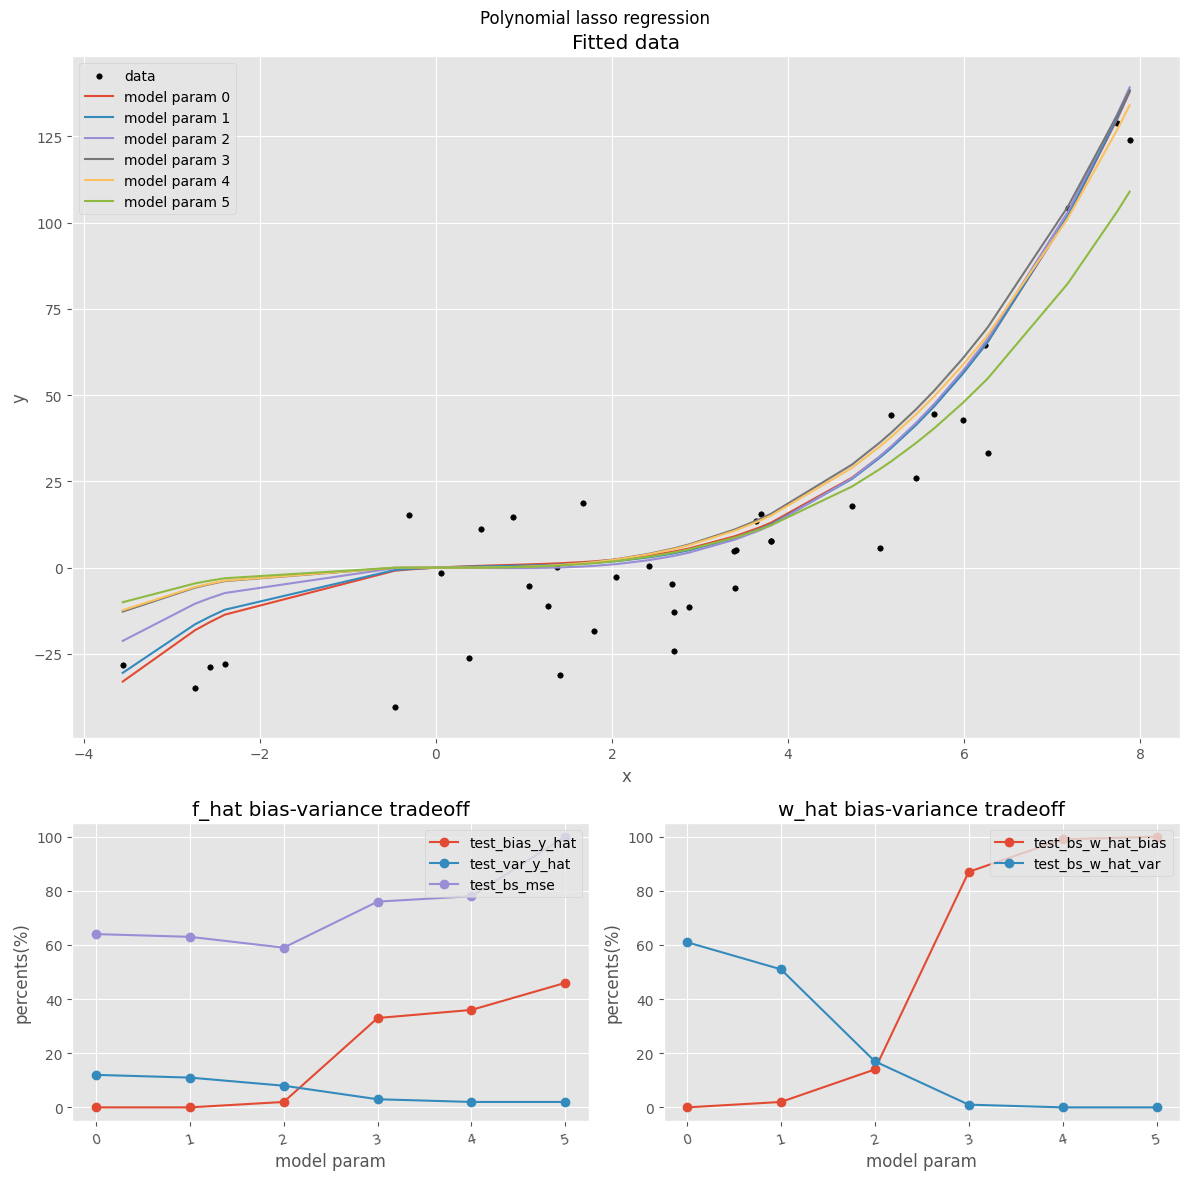

In [13]:
plot(cv_scores, range(len(alphas)), x, y, y_hats, title="Polynomial lasso regression")